# Python codes for ch3 exercise

In [617]:
import os, time, sys
import functools
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
from nltk.corpus import stopwords
from gensim import corpora
from six import iteritems
from fractions import Fraction

In [618]:
spam_path='/root/app/ML_for_Hackers/03-Classification/data/spam/'

In [619]:
spam_files=[f for f in os.listdir(spam_path) if f != 'cmds']

In [706]:
def get_token_list(file):
    '''
    This function is for generation of text tokens using a redexp.
    Input is file path.
    Output is a list containing all the tokens.
    Word tokes are filterd to remove any stopwords for english
    '''

    # select only word containing alphabets
    tokenizer = RegexpTokenizer(r'[A-Za-z]+')
    count=0
    t=list()
    
    with open(file, 'r', encoding='latin1') as infile:
        for l in infile:
            #l.strip('\n') 
            l.strip() 
            if l !="":
                '''
                Skip the file until the first emply line
                '''
                count=1
            if (count==1) & (l !=""): 
                '''
                If the line is non-empty and satisfying all conditions
                '''
                s=tokenizer.tokenize(l.lower())  
                t.extend(s)
    return t

In [707]:
def get_email_training_set(files, path):
    '''
    This function is for getting a training set dataframe
    from the training documents
    Output is a dataframe containing the term, frequency, density and occurrence
    '''
    
    # get all spam words as a list of lists
    words=list(map(lambda x: get_token_list(os.path.join(path,x)), files))
    
    # creating gensim dictionary with the word list
    dictionary = corpora.Dictionary(words)
    
    # flatten to a list
    words=[w for sublist in words for w in sublist]
 
    # calculate word frequencey
    fdist=FreqDist(words)
    
    # Dataframe for word frequency count
    spam_fdist_df=pd.DataFrame.from_dict(dict(fdist), orient='index' )
    
    # creating stopword list
    cached_stopwords=set(stopwords.words('english'))
    stop_words = set([stopword for stopword in cached_stopwords
              if stopword in dictionary.token2id])

    stop_ids  = [dictionary.token2id[stopword] for stopword in cached_stopwords
              if stopword in dictionary.token2id]
    
    # filter dictionary
    dictionary.filter_tokens(stop_ids)

    # remove gaps in id sequence after words that were removed
    dictionary.compactify()
    
    # Prepare dataframe for word occurrence
    word_df=pd.DataFrame.from_dict({dictionary[termid]:docfreq 
                                    for termid, docfreq in iteritems(dictionary.dfs)}, 
                                   orient='index')
    word_df.columns=['occurrence_count']
    
    # Remove stopwords from data frame
    spam_fdist_df=spam_fdist_df.drop(stop_words)
    
    # rename column
    spam_fdist_df.columns=['frequency']
    
    # Merge dataframes
    merged_df=pd.concat([spam_fdist_df, word_df],axis=1,join='inner')
    
    # Set minimun frequency as 2
    merged_df=merged_df[merged_df.frequency > 1]
    
    # calculating spam density
    merged_df['density']=merged_df.frequency/merged_df.frequency.sum()
    
    # Calculating spam occurrence
    merged_df['occurrence']=merged_df.occurrence_count/len(spam_files)
    
    # Sort dataframe
    merged_df.sort_values('occurrence', inplace=True)
    
    # Removing numeric index values
    merged_df=merged_df.loc[~merged_df.index.map(lambda x: x.isnumeric())]
    
    # Removing email specific words
    merged_df=merged_df.drop(['message','id','subject','date','org','received'])
    
    return merged_df

In [708]:
spam_df=get_email_training_set(files=spam_files, path=spam_path)

In [709]:
easyham_path='/root/app/ML_for_Hackers/03-Classification/data/easy_ham/'

In [710]:
easyham_files=[f for f in os.listdir(easyham_path) if f != 'cmds']

In [711]:
easyham_df=get_email_training_set(files=easyham_files[0:500], path=easyham_path)

In [712]:
def calcupate_prob(file, training_df, prior=0.5, c=1e-3):
    '''
    This function is for calculating SPAM probability of a
    document. A training data frame is required for this calculation.
    '''
    
    # get all token list for document
    words=get_token_list(file)
    
    # calculate dist
    fdist=FreqDist(words)
    
    # creating gensim dictionary with the word list
    dictionary = corpora.Dictionary([words])
    
    # creating stopword list
    cached_stopwords=set(stopwords.words('english'))
    stop_words = set([stopword for stopword in cached_stopwords
              if stopword in dictionary.token2id])
    
    # Dataframe for word frequency count
    spam_fdist_df=pd.DataFrame.from_dict(dict(fdist), orient='index' )
    
    # Remove stopwords from data frame
    spam_fdist_df=spam_fdist_df.drop(stop_words)
    
    # Removing numeric index values
    spam_fdist_df=spam_fdist_df.loc[~spam_fdist_df.index.map(lambda x: x.isnumeric())]
    
    # Get occurrence probability of all words
    word_occurrence_prob=list()

    match_index=training_df.index.intersection(spam_fdist_df.index)
    match_series=training_df.loc[match_index].occurrence
    
    
    msg_prob=1.0
    match_count=0
      
    match_count=match_series.count()
    if match_count > 0: 
        msg_prob=match_series.product()
        
    return (prior*msg_prob*pow(c, len(spam_fdist_df.index)-match_count))

In [713]:
spam_2_file_path='/root/app/ML_for_Hackers/03-Classification/data/spam_2/'
spam_2_files=[f for f in os.listdir(spam_2_file_path) if f != 'cmds']

In [714]:
test_prob=calcupate_prob(file=os.path.join(spam_2_file_path, spam_2_files[300]),training_df=spam_df)

In [715]:
test_prob

5.451385431569964e-134

In [716]:
easy_ham_2_file_path='/root/app/ML_for_Hackers/03-Classification/data/easy_ham_2/'
easy_ham_2_files=[f for f in os.listdir(easy_ham_2_file_path) if f != 'cmds']

In [717]:
test_prob=calcupate_prob(file=os.path.join(easy_ham_2_file_path, easy_ham_2_files[80]),training_df=spam_df)

In [718]:
def classify_mail(path, files, lable, training_spam=spam_df,training_ham=easyham_df):
    '''
    This function accepts a file path, a list of input files, 
    a text lable and training dfs. It utilises calculate_prob 
    function for score calculation. Output is a data frame with 
    following collums
    
    PR_SPAM: Spam probability
    PR_HAM: Ham probability
    CLASS: 1 if classified as SPAM or 0
    LABLE: Same as input lable
    '''
    
    # Calculate spam scores
    spam_scores=list(map(lambda x: calcupate_prob(file=os.path.join(path, x),
                                                  training_df=training_spam), 
                         files))
    
    # Calculate ham scores
    ham_scores=list(map(lambda x: calcupate_prob(file=os.path.join(path, x),
                                                  training_df=training_ham), 
                         files))
    
    # Add scores to data frame
    result_df=pd.DataFrame({'PR_SPAM': spam_scores, 'PR_HAM': ham_scores})
    
    # Add class
    result_df['CLASS']=np.where(result_df['PR_SPAM'] > result_df['PR_HAM'], 1, 0)
    
    # Add lable
    result_df['LABLE']=lable
    
    return result_df

In [719]:
# get spam result dataframe
spam_2_result_df=classify_mail(path=spam_2_file_path, files=spam_2_files, 
                               lable='SPAM_2', training_spam=spam_df,
                               training_ham=easyham_df)

In [721]:
spam_2_result_df[spam_2_result_df.CLASS==1].count()

PR_HAM     901
PR_SPAM    901
CLASS      901
LABLE      901
dtype: int64

In [723]:
# get easyham result dataframe
easy_ham_2_result_df=classify_mail(path=easy_ham_2_file_path, files=easy_ham_2_files, 
                               lable='EASYHAM_2', training_spam=spam_df,
                               training_ham=easyham_df)

In [725]:
easy_ham_2_result_df[easy_ham_2_result_df.CLASS==0].count()

PR_HAM     1330
PR_SPAM    1330
CLASS      1330
LABLE      1330
dtype: int64

In [726]:
hard_ham_2_file_path='/root/app/ML_for_Hackers/03-Classification/data/hard_ham_2/'
hard_ham_2_files=[f for f in os.listdir(hard_ham_2_file_path) if f != 'cmds']

In [727]:
# get hardham result dataframe
hard_ham_2_result_df=classify_mail(path=hard_ham_2_file_path, files=hard_ham_2_files, 
                               lable='HARDHAM_2', training_spam=spam_df,
                               training_ham=easyham_df)

In [729]:
hard_ham_2_result_df[hard_ham_2_result_df.CLASS==1].count()

PR_HAM     25
PR_SPAM    25
CLASS      25
LABLE      25
dtype: int64

In [730]:
merged_df=pd.concat([spam_2_result_df, easy_ham_2_result_df, hard_ham_2_result_df], axis=0)

In [731]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3045 entries, 0 to 247
Data columns (total 4 columns):
PR_HAM     3045 non-null float64
PR_SPAM    3045 non-null float64
CLASS      3045 non-null int32
LABLE      3045 non-null object
dtypes: float64(2), int32(1), object(1)
memory usage: 95.2+ KB


In [735]:
merged_df.groupby(['LABLE', 'CLASS']).count()

PR_HAM  PR_SPAM
LABLE     CLASS                 
EASYHAM_2 0        1330     1330
          1          70       70
HARDHAM_2 0         223      223
          1          25       25
SPAM_2    0         496      496
          1         901      901

In [739]:
merged_df['LOG(PR_SPAM)']=merged_df.PR_SPAM.apply(np.log)

In [740]:
merged_df['LOG(PR_HAM)']=merged_df.PR_HAM.apply(np.log)

In [741]:
merged_df.head()

,PR_HAM,PR_SPAM,CLASS,LABLE,LOG(PR_SPAM),LOG(PR_HAM)
0,0.000000e+00,0.000000e+00,0,SPAM_2,-inf,-inf
1,3.007269e-201,1.211079e-163,1,SPAM_2,-375.129859,-461.718571
2,5.142378e-129,7.058543e-97,1,SPAM_2,-221.396515,-295.395961
3,0.000000e+00,0.000000e+00,0,SPAM_2,-inf,-inf
4,1.445066e-273,7.814839e-184,1,SPAM_2,-421.619633,-628.237575


In [752]:
# Replace inf values to Nan and removing them from data frame
merged_df=merged_df.replace([np.inf, -np.inf], np.nan).dropna()

In [756]:
import matplotlib.pyplot as plt

In [775]:
spam_group_df=merged_df.groupby(['CLASS']).get_group(0)
ham_group_df=merged_df.groupby(['CLASS']).get_group(1)

In [789]:
color_key={'SPAM_2':'red', 'EASYHAM_2':'green', 'HARDHAM_2':'gold'}

In [831]:
lable_key={1:'D', 0:'o'}

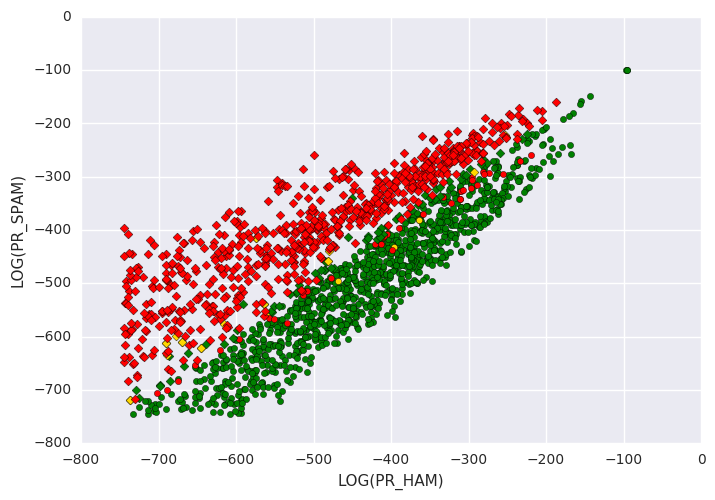

In [834]:
fig, ax=plt.subplots()

for c, groupA in merged_df.groupby(['CLASS']):
    for l, groupB in groupA.groupby(['LABLE']):
        color_val=color_key[l]
        lable_val=lable_key[c]
        
        groupB.plot(ax=ax, kind='scatter', x='LOG(PR_HAM)', y='LOG(PR_SPAM)', 
                    marker=lable_val, color=color_val)
plt.show()